"""The goal of this project is to develop a pipeline to detect lane lines for a self driving car"""

In [2]:
#import libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

In [3]:
"""
The first step is to calibrate the camera using images of chess boards.  
We have about 20 images of chessboards with 9x6=54 internal corners that we can use to calibrate the camera
(It is recommended that we use at least 20 images to calibrate the camera.) 

First, we create a 3d array called objp which represents the 3 dimensional coordinate
location of all the the chessboard corners.

We then initialize objpoints to store the aforementioned 3d points as well as imgpoints to store 
the 2d chesspoint corners that we find.

We use opencv to convert the images to grayscale, we then use cv2.findChessboardCorners() 
to obtain the chessboard corners from the image. 

We then append these results to objpoints and imgpoints

In the next step, we create an undistort() function that uses the objpoints and imgpoints that we obtained
from the previous step to calibrate the camera.   After the camera has been calibrated, we can use the parameters 
obtained to undistort all the road images using cv2.undistort(img, mtx, dist, None, mtx)

Below, I have visualized the original (distorted) and undistorted images.  The difference between the distorted and 
undistorted image is not immediately obvious, as most of the distortion appears on the edges of the image. 

However, if you look closely at the edges of the image, you can see the areas where the distortion has been corrected

"""

'\nThe first step is to calibrate the camera using images of chess boards.  \nWe have about 20 images of chessboards with 9x6=54 internal corners that we can use to calibrate the camera\n(It is recommended that we use at least 20 images to calibrate the camera.) \n\nFirst, we create a 3d array called objp which represents the 3 dimensional coordinate\nlocation of all the the chessboard corners.\n\nWe then initialize objpoints to store the aforementioned 3d points as well as imgpoints to store \nthe 2d chesspoint corners that we find.\n\nWe use opencv to convert the images to grayscale, we then use cv2.findChessboardCorners() \nto obtain the chessboard corners from the image. \n\nWe then append these results to objpoints and imgpoints\n\nIn the next step, we create an undistort() function that uses the objpoints and imgpoints that we obtained\nfrom the previous step to calibrate the camera.   After the camera has been calibrated, we can use the parameters \nobtained to undistort all the

In [130]:
def get_calibration_points(ret=True):
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) #creates a 3d point for each of the chessboard corners

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob('camera_cal/calibration*.jpg')

    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
            ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
            ax1.set_title('original', fontsize=18)
            ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax2.set_title('/w corners', fontsize=18)
            
    return objpoints, imgpoints

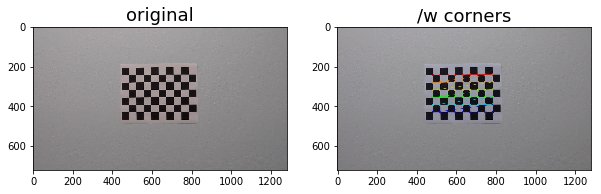

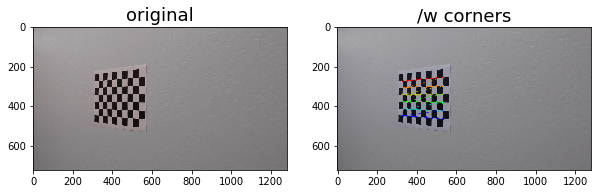

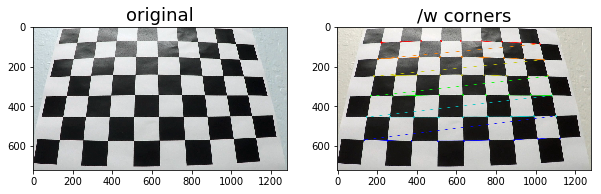

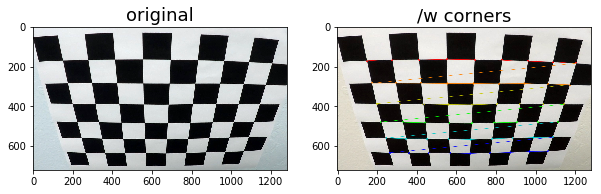

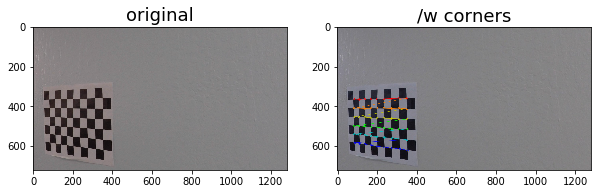

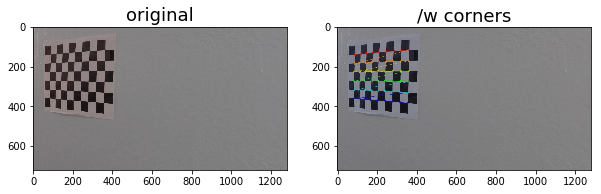

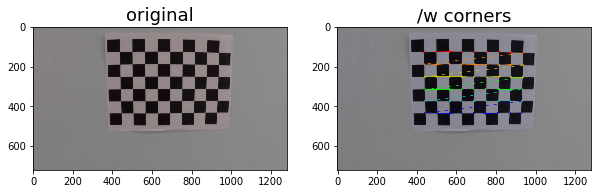

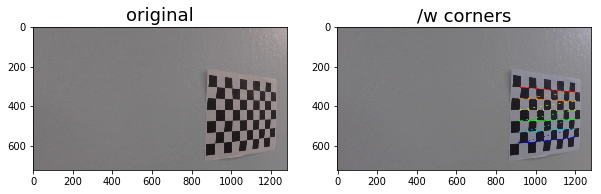

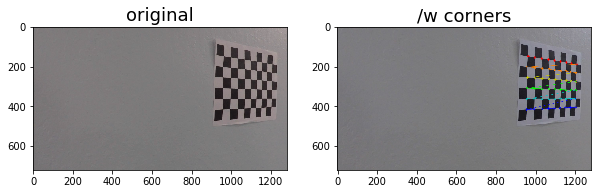

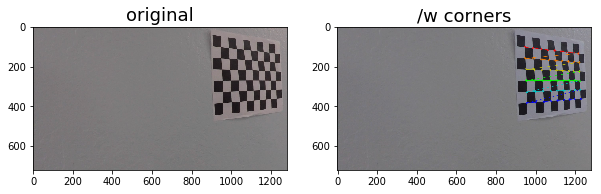

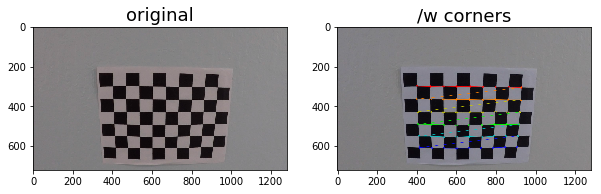

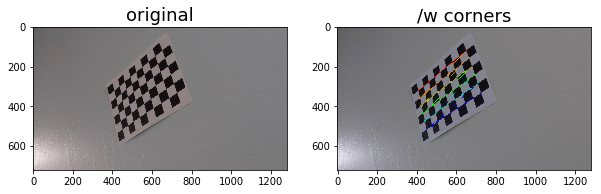

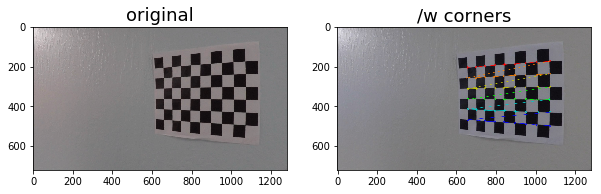

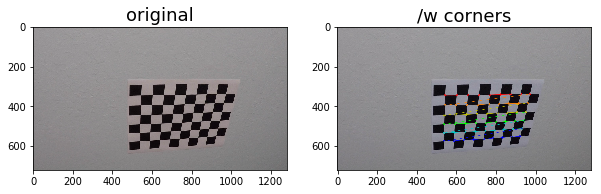

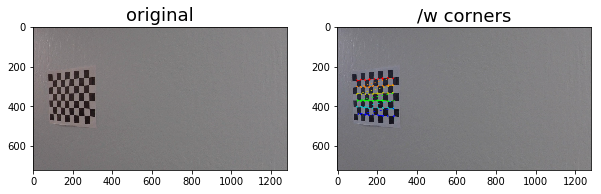

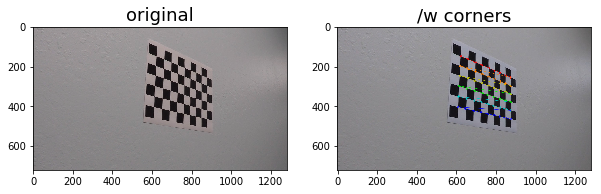

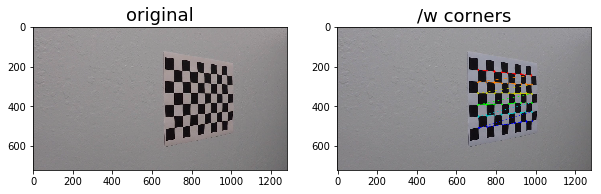

In [131]:
objpoints, imgpoints = get_calibration_points()

In [17]:
# Remove distortion from images
def undistort(image, show=True, read = True):
    if read:
        image = cv2.imread(image)
    img_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,12))
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    else:
        return undist

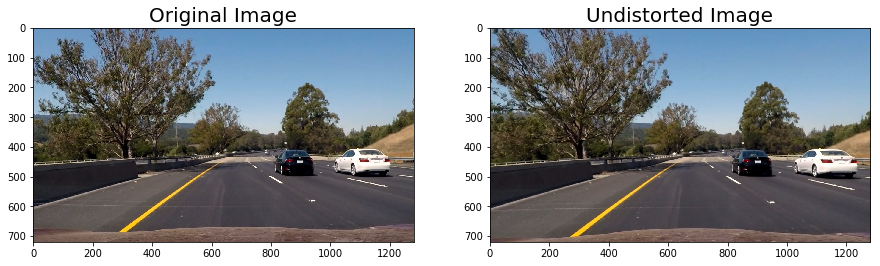

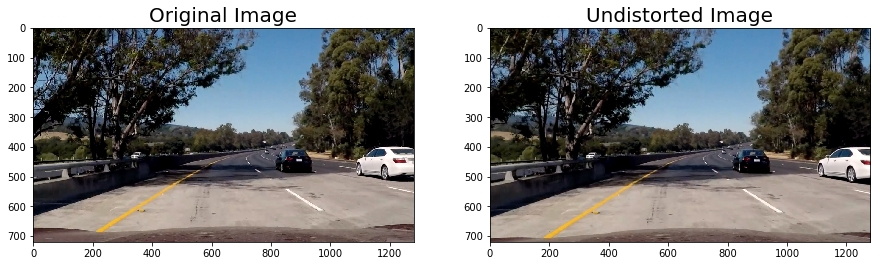

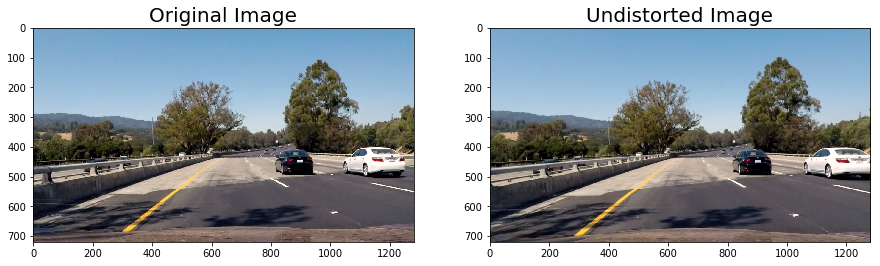

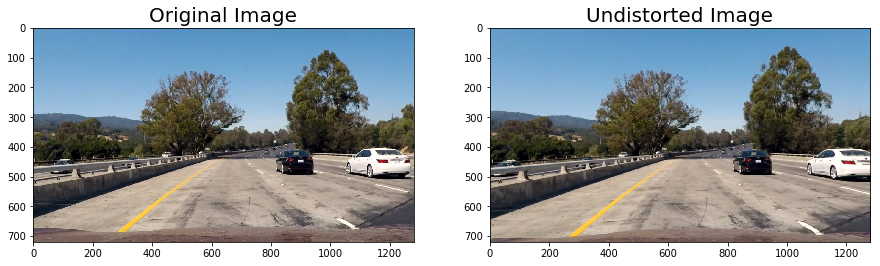

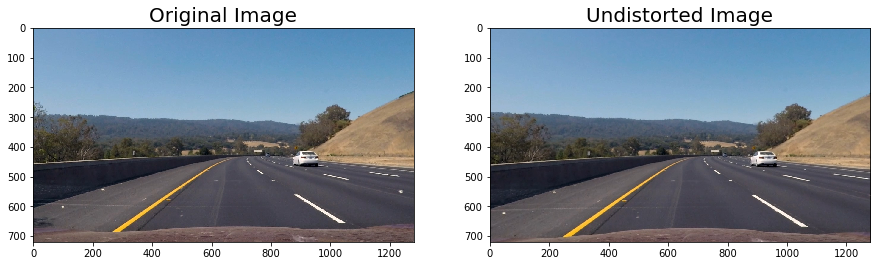

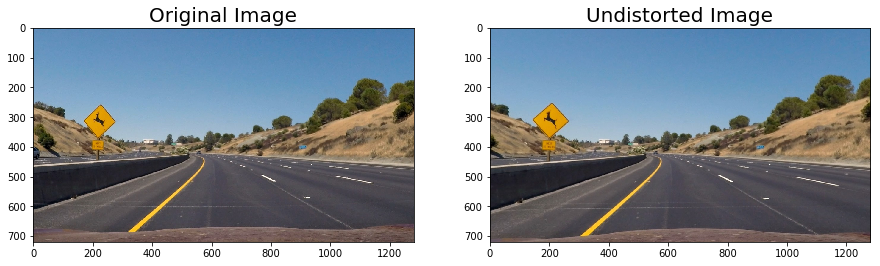

In [18]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    undistort(image)

In [134]:
# Perform perspective transform to get a top down view of the road
def get_top_down(img, display=True, read = True):
    if read:
        undist = undistort(img, show = False)
    else:
        undist = undistort(img, show = False, read=False) 
    img_size = (undist.shape[1], undist.shape[0])
    
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    
    #destination points were calculated visually.
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)  #compute the perspective transform
    warped = cv2.warpPerspective(undist, M, img_size)  #warp the image using hte perspective transform
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        #f.tight_layout()
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped, M

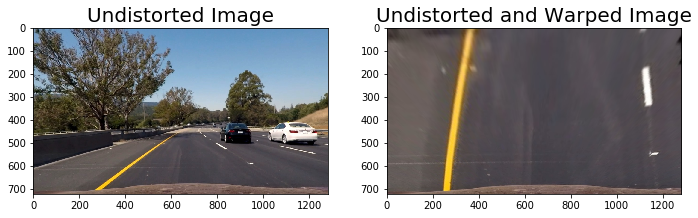

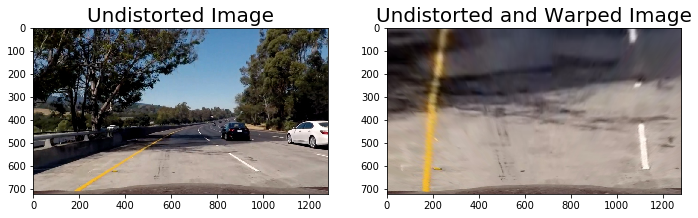

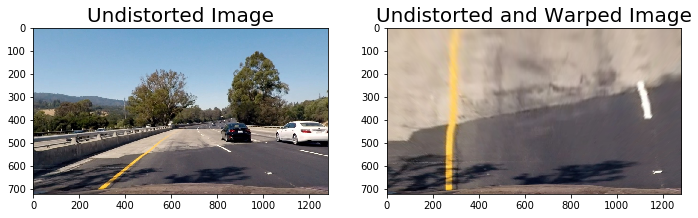

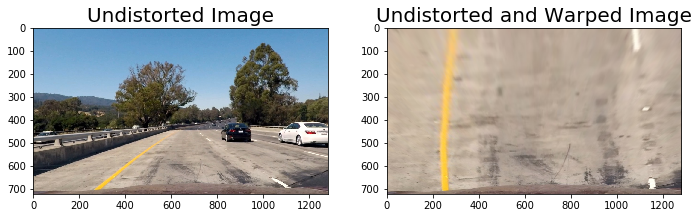

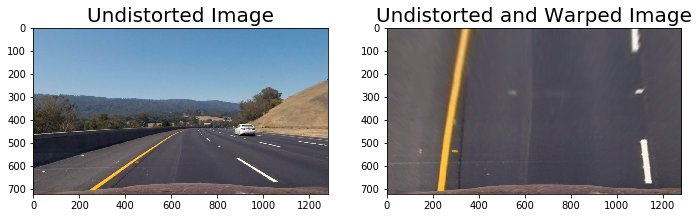

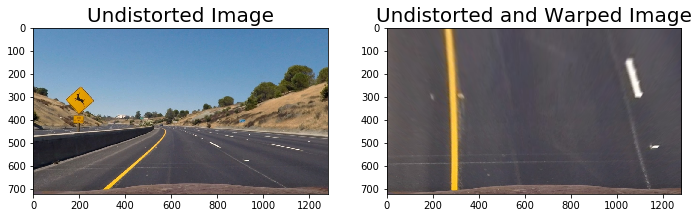

In [135]:
for image in glob.glob('test_images/test*.jpg'):
    get_top_down(image)

In [10]:
"""
After the perspective transform, we will now apply color thresholding to isolate the lane line

For the color thresholds, I isolated the "lightness" channel from the hls colorspace
and the "blue-yellow" channel from the lab colorspace

The "lightness" from the hls channel was very useful for isolating the white lane lines and the "blue-yellow"
channel from the lab colorspace was very good for getting the yellow lines.

I had to test out a number of thresholds before I got the optimal ones.  I tested out different channels from 
various color spaces including LUV, HSV, HLS, LAB, and I tried various gradient thresholds.  Ultimately, 
I did not use the gradient thresholds and simply used channels from two colorspaces.

After that, I combined the two binary maps to get the final isolated lane lines.

You can see from the results below that the thresholds chosen do a pretty good job of isolating the lane lines 

"""

'\nAfter the perspective transform, we will now apply color thresholding to isolate the lane line\n\nFor the color thresholds, I isolated the "lightness" channel from the hls colorspace\nand the "blue-yellow" channel from the lab colorspace\n\nThe "lightness" from the hls channel was very useful for isolating the white lane lines and the "blue-yellow"\nchannel from the lab colorspace was very good for getting the yellow lines.\n\nI had to test out a number of thresholds before I got the optimal ones.  I tested out different channels from \nvarious color spaces including LUV, HSV, HLS, LAB, and I tried various gradient thresholds.  Ultimately, \nI did not use the gradient thresholds and simply used channels from two colorspaces.\n\nAfter that, I combined the two binary maps to get the final isolated lane lines.\n\nYou can see from the results below that \n\n'

In [21]:
# Create binary thresholded images to isolate lane line pixels
def apply_thresholds(image, show=True):
    img, M = get_top_down(image, display = False)
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,1]  #get the lightness "l" channel from hls
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]  #get blue-yellow "b" channel from lab 

    l_thresh_min = 230
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    b_thresh_min = 155
    b_thresh_max = 205
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    combined_binary = np.zeros_like(l_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1  #use l and b binary

    if show == True:
        # Plotting thresholded images
        f, ((ax1, ax2, ax3,ax4,ax5)) = plt.subplots(1, 5, sharey='col', sharex='row', figsize=(24,3))
        f.tight_layout()
        
        ax1.set_title('Original Image', fontsize=16)
        ax1.imshow(cv2.cvtColor(undistort(image, show=False),cv2.COLOR_BGR2RGB))
        
        ax2.set_title('Warped Image', fontsize=16)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax3.set_title('b binary threshold', fontsize=16)
        ax3.imshow(b_binary, cmap='gray')
        
        ax4.set_title('l binary threshold', fontsize=16)
        ax4.imshow(l_binary, cmap='gray')

        ax5.set_title('Combined color thresholds', fontsize=16)
        ax5.imshow(combined_binary, cmap='gray')
        
    else: 
        return combined_binary

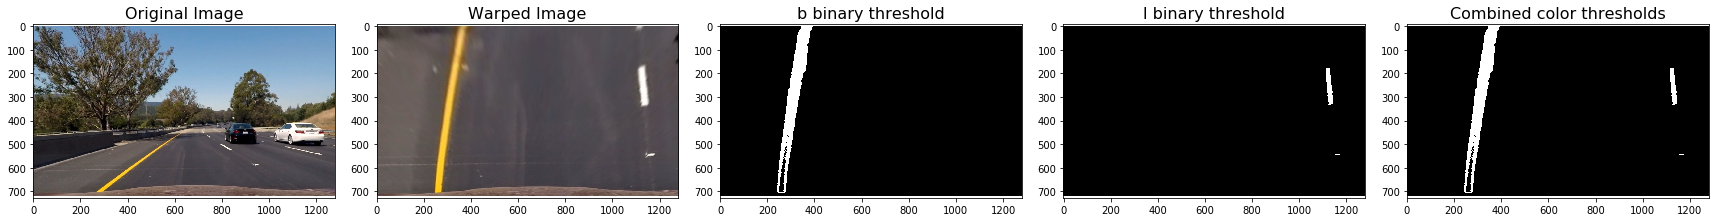

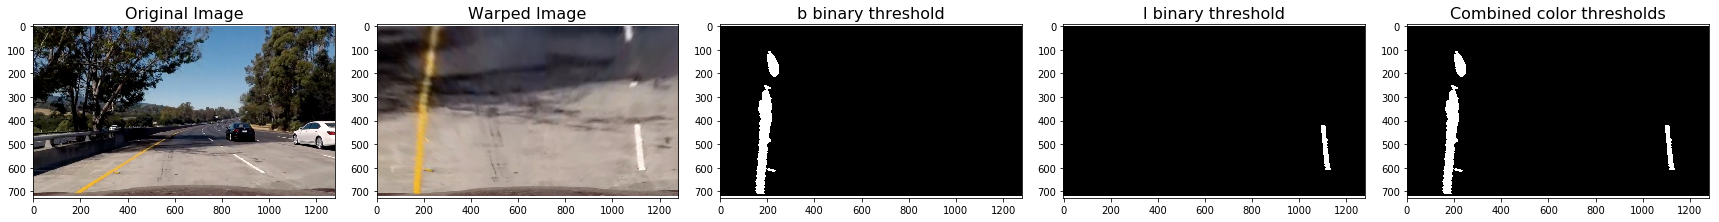

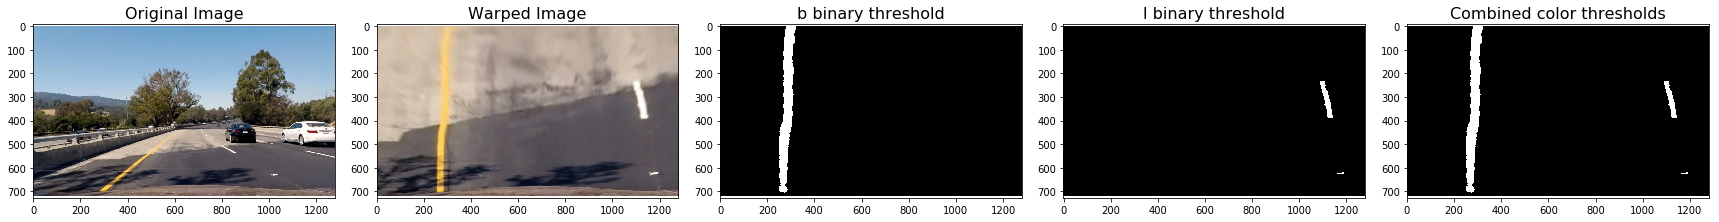

In [22]:
for image in glob.glob('test_images/test*.jpg')[0:3]:
    apply_thresholds(image)

In [136]:
"""
The next step is to detect the lane lines.

In the function fit_lane_lines() below, lane lines are detected by identifying 
peaks in a histogram on the bottom portion of the image and detecting nonzero pixels in close proximity to the peaks.

After the pixels have been identified, a sliding windows approach is used to detect the pixels for the entire line.  
Once all the pixels have been identified for both the left and right lanes, a best fit line is calculated using 
a second order polynomial using np.polyfit().

The vehicle center is calculated by average the x coordidinates of the left and right lane lines
and then finding the midpoint between the two

After the lane lines have been fit and drawn onto the image, a reverse perspective transform is applied.
"""

'\nThe next step is to detect the lane lines.\n\nIn the function fill_lane() below, lane lines are detected by identifying \npeaks in a histogram on the bottom portion of the image and detecting nonzero pixels in close proximity to the peaks.\n\nAfter the pixels have been identified, a sliding windows approach is used to detect the pixels for the entire line.  \nOnce all the pixels have been identified for both the left and right lanes, a best fit line is calculated using \na second order polynomial using np.polyfit().\n\nThe vehicle center is calculated by average the x coordidinates of the left and right lane lines\nand then finding the midpoint between the two\n\nAfter the lane lines have been fit and drawn onto the image, a reverse perspective transform is applied.\n'

In [ ]:
def fit_lane_lines(image):
    combined_binary = apply_thresholds(image, show=False)
    
    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    x, y = np.nonzero(np.transpose(combined_binary))  #get the x and y coordinates of non zero points
    
    """
    sliding window from bottom to top of image, storing the indices of nonzero pixels in 
    leftx and righty, representing the left and right lane lines
    """
    num_of_windows = 8
    margin = 25 #margin around the histogram peak to search for
    window_size = combined_binary.shape[0] // num_of_windows
    cur = combined_binary.shape[0] - window_size #current location of the window
    
    while cur >= 0:
        histogram = np.sum(combined_binary[cur:cur + window_size,:], axis=0) #compute histogram
        
        #left line
        left_peak = np.argmax(histogram[:combined_binary.shape[1]//2])
        x_idx = np.where(((left_peak - margin) < x)&(x < (left_peak + margin))&((y > cur)&(y < cur + window_size))) #get x indices inside the window
        x_window, y_window = x[x_idx], y[x_idx] #get non zero elements inside the window
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())
        
        #right line
        right_peak = np.argmax(histogram[combined_binary.shape[1]//2:]) + combined_binary.shape[1]//2
        x_idx = np.where(((right_peak - margin) < x)&(x < (right_peak + margin))&((y > cur)&(y < cur + window_size)))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        
        cur -= window_size

    """
    fit line to left and right lane pixel using np.polyfit()
    
    After fitting the initial line, 
    """
    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]

    #calculate bottom and top values from fit and append to the fitted values
    #the reason that we do this is for the dotted line lanes, we do not have points for the entire line.
    rightx_bottom = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx_top = right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2]
    rightx = np.append(rightx,rightx_bottom)
    rightx = np.append(rightx,rightx_top)
    righty = np.append(righty, 720)
    righty = np.append(righty, 0)
    
    leftx_bottom = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    leftx_top = left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2]
    leftx = np.append(leftx, leftx_bottom)
    leftx = np.append(leftx,leftx_top)
    lefty = np.append(lefty, 720)
    lefty = np.append(lefty, 0)
    
    #sort the newly append values by the y indices
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    ### Measure Radius of Curvature for each lane line
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    #calulate the curve radius
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    # Calculate the position of the vehicle by finding midpoint between left and right lines
    center = abs(combined_binary.shape[1]//2 - ((rightx_bottom + leftx_bottom)/2)) 

    #params for reverse perspective transform
    img_size = (combined_binary.shape[1], combined_binary.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #create empty canvas for applying lines
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    #prepare the left and right fitted points
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    
    #draw fitted lane lines on the empty canvas, as well as fill in the space between the lines 
    #apply reverse perpsective transform and overlay onto original image to get the final result
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,255,0), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,100,100))
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size)
    result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0) #add transparent overlay on to original image
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 9))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor((get_top_down(image, display=False)[0]), cv2.COLOR_BGR2RGB))
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(0, 720)
    ax1.plot(left_fitx, lefty, color='green', linewidth=3)
    ax1.plot(right_fitx, righty, color='green', linewidth=3)
    ax1.set_title('Fit Polynomial to Lane Lines', fontsize=16)
    ax1.invert_yaxis() # to visualize as we do the images
    ax2.imshow(result)
    ax2.set_title('Fill Lane Between Polynomials', fontsize=16)
    if center < 640:
        ax2.text(200, 100, 'Vehicle is: {:.2f}m left of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=20)
    else:
        ax2.text(200, 100, 'Vehicle is: {:.2f}m right of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=20)
    ax2.text(200, 175, 'Radius of curvature is: {}m'.format(int((left_curverad + right_curverad)/2)),
             style='italic', color='white', fontsize=20)

In [ ]:
for image in glob.glob('test_images/test*.jpg'):
    fit_lane_lines(image)

In [154]:
"""
A class (Line) is used to store the parameters for the lane line from the previous frames.

"""

'\nA class (Line) is used to store the parameters for the lane line from the previous frames.\n\n'

In [ ]:
class Line:
    def __init__(self):
        # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def blind_search(self, x, y, image):
        '''
        This function is applied in the first few frames and/or if the lane was not successfully detected
        in the previous frame. It uses a slinding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        '''
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

In [ ]:
# Video Processing Pipeline
def process_vid(image):
    img_size = (image.shape[1], image.shape[0])
    
    # Calibrate camera and undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Perform perspective transform
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # Generate binary thresholded images
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # Set the upper and lower thresholds for the b channel
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # Set the upper and lower thresholds for the l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if Left.found == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.found_search(x, y)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.found_search(x, y)

            
    if Right.found == False: # Perform blind search for right lane lines
        rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)
            
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        
    # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    Left.count += 1
    return result

In [ ]:
Left = Line()
Right = Line()
video_output = 'result.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(0,2)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

In [ ]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))

In [ ]:
Left = Line()
Right = Line()
challenge_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip1.fl_image(process_vid) 
challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('challenge_result.mp4'))